In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Angular Spectrum Propagation (phase & amplitude)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: ',device)

Using Device:  cuda


### ***Loading and Viewing Dataset***

batch_number [100/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


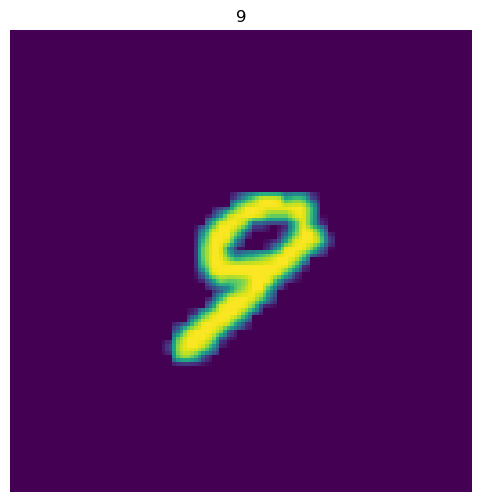

batch_number [200/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


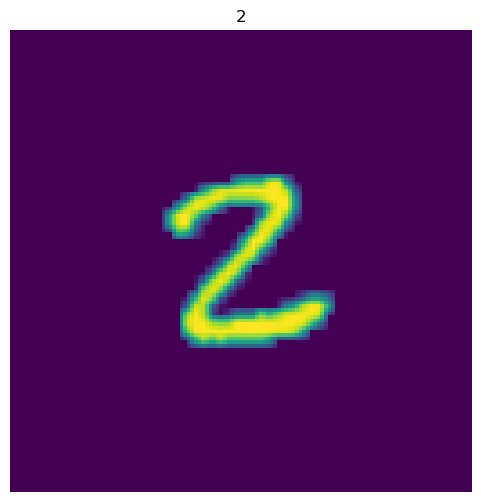

batch_number [300/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


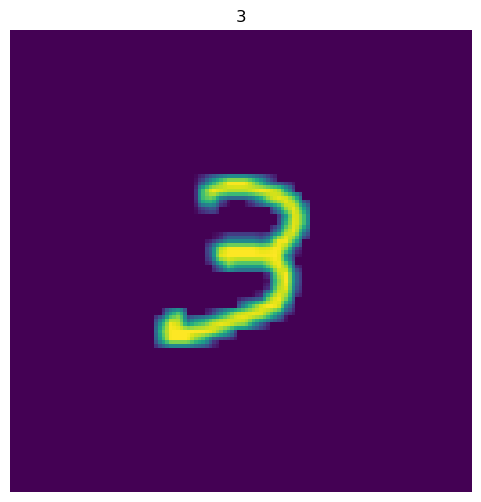

In [3]:
BATCH_SIZE = 200
IMG_SIZE = 64
N_pixels = 128
PADDING = (N_pixels - IMG_SIZE) // 2  # 避免边缘信息丢失

# 数据预处理并加载
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.Pad([PADDING, PADDING], fill=(0), padding_mode='constant'),
#                                 transforms.Normalize((0.1307,), (0.3081,))
                               ]
                               )
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定义一个绘图函数
def image_plot(image, label):
#     cmap='RdBu'
    fig, ax = plt.subplots()
    ax.imshow(np.round(image.cpu().numpy(), 5)) # 显示图片每个像素点的振幅
    ax.axis('off')
    ax.set_title(label.cpu().numpy())
#     fig.colorbar(plt.cm.ScalarMappable(cmap=cmap))
    plt.show()

plt.rcParams["figure.figsize"] = (20, 6)
for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
#     images_E = torch.sqrt((torch.squeeze(images)+1)/2)
    images_E = torch.sqrt(torch.squeeze(images))
    labels = labels.to(device)

    '''
        每一个周期，共300个批次（i=0~299），一共60000个数据；
        train_dataloader包含300个批次，包括整个训练集；
        每一批次一共200张图片，对应200个标签, len(images[0])=1；
        images包含一个批次的200张图片（image[0].shape=torch.Size([1,28,28])），labels包含一个批次的200个标签，标签范围为0~9
    '''

    #每100个批次绘制第一张图片（含shuffle导致每次运行结果不一样）
    if (i + 1) % 100 == 0:
        classes = torch.unique(labels).cpu().numpy()
        classes_num = len(classes)
        print('batch_number [{}/{}]'.format(i + 1, len(train_dataloader)))
        print('classes of the first batch: {}, number of classes: {}'.format(classes, classes_num))#  第一个batch的总类
#         image_plot(images_phase[0], labels[0])
        image_plot(images_E[0], labels[0])


In [4]:
images_E.shape

torch.Size([200, 128, 128])

### ***Diffractive Layer***

In [5]:
class Diffractive_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为532e-9，网格总数50，网格大小2e-6，z方向传播0.002。
    def __init__(self, λ = 532e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.005])):
        super(Diffractive_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c).to(device) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

### ***Propagation Layer***

In [6]:
class Propagation_Layer(torch.nn.Module):
    # 与上面衍射层大致相同，区别在于传输层是最后一个衍射层到探测器层间的部分，中间可以自定义加额外的器件。
    def __init__(self, λ = 532e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.001])):
        super(Propagation_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

In [7]:
def propagation_along_z(initial_field, wl, N_pixels, pixel_size, z_step, number_of_z_steps):
    diffraction_step = Diffractive_Layer(distance = torch.tensor(z_step), λ = wl, N_pixels = N_pixels, pixel_size = pixel_size)
    z_ind = np.arange(0, number_of_z_steps)
    full_cross_section =  torch.zeros((len(z_ind),N_pixels, N_pixels),dtype = torch.complex64)
    full_cross_section[0] = torch.tensor(initial_field)
    with torch.no_grad():
        for ind in z_ind[1:]:
            full_cross_section[ind] = diffraction_step(full_cross_section[ind-1])
        return full_cross_section

DISCRETIZATION_STEP = 2.0e-6 # 网格大小
N_pixels = 128 # xy平面边长的元素点数量
z_step = 1e-5 # z方向步长
number_of_z_steps = 500 # z方向步数
z = np.arange(0, number_of_z_steps)*z_step # z坐标
wl = 532e-9 # 波长
coord_limit = (N_pixels//2)*DISCRETIZATION_STEP # 建立xy坐标系
# 拉网格
mesh = np.arange(-coord_limit, coord_limit, DISCRETIZATION_STEP)
x, y = np.meshgrid(mesh, mesh)

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\2852547191.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\2852547191.py:12: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('y ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\2852547191.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel('y ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\2852547191.py:23: Synta

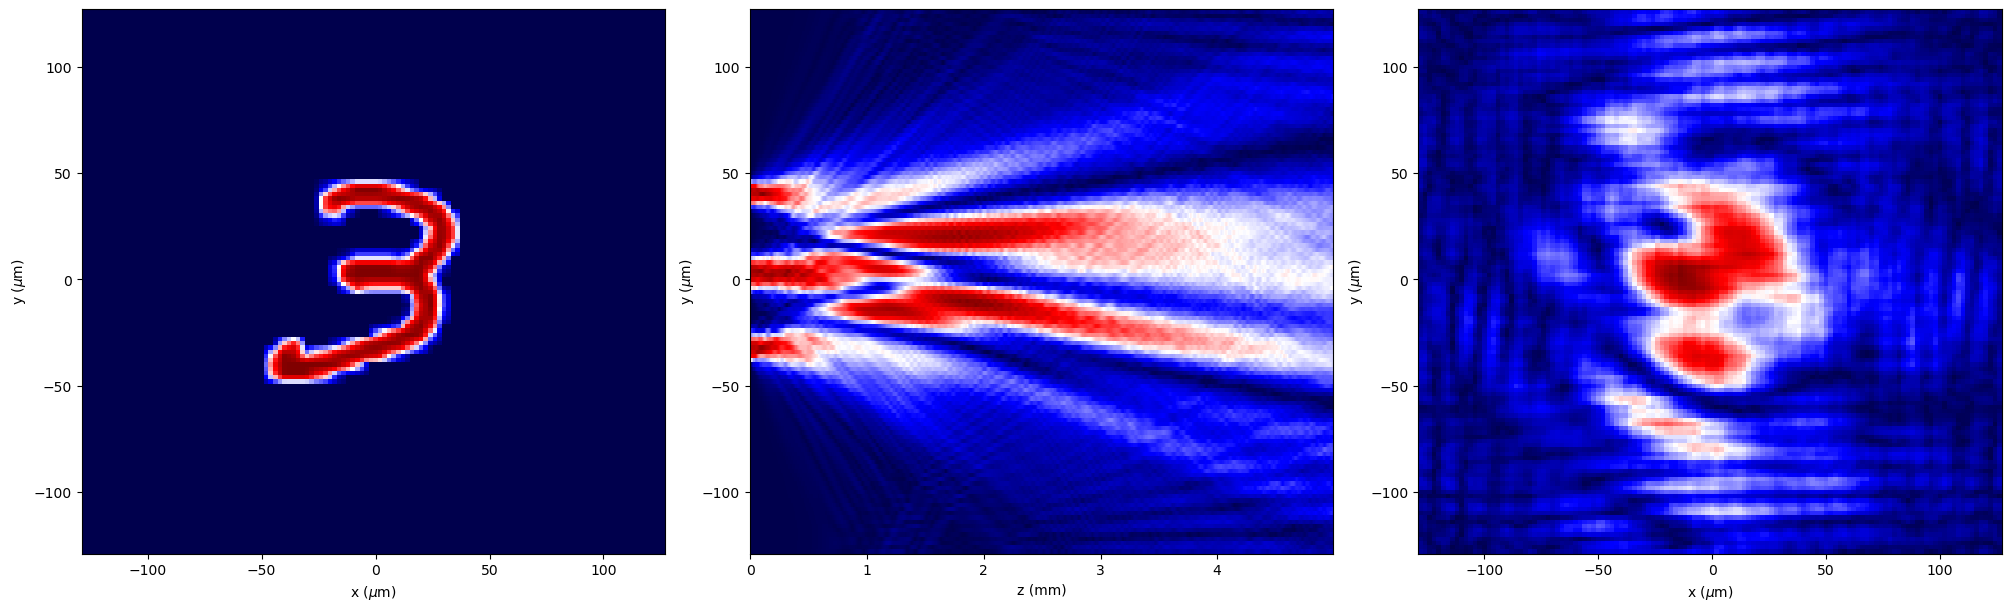

In [8]:
images_input = torch.flip(images_E[0], [0])
field = propagation_along_z(images_input, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

plt.rcParams["figure.figsize"] = (20, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
cmap = 'seismic'

# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap=cmap)
ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')

# yz cross-section
YZ_field = torch.abs(field[:, :, N_pixels//2])
ax2.pcolormesh(z*10**3, mesh*10**6, YZ_field.T, cmap=cmap)
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')

# output
XY_field_out = torch.abs(field[-1]).T
ax3.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax3.set_xlabel('x ($\mu$m)')
ax3.set_ylabel('y ($\mu$m)')

plt.show()

In [9]:
class Lens_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为532e-9，网格总数50，网格大小20e-6，z方向传播0.002。
    def __init__(self, f = 5e-3, wl = 532e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.005])):
        super(Lens_Layer, self).__init__() # 初始化父类
        # 网格大小
        coord_limit = (N_pixels//2)*pixel_size # 建立xy坐标系
        # 拉网格
        mesh = np.arange(-coord_limit, coord_limit, pixel_size)
        x, y = np.meshgrid(mesh, mesh)
        self.phase_lens = torch.tensor(np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))).to(device)
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / wl) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c).to(device) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum*self.phase_lens

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\601910562.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\601910562.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('y ($\mu$m)')


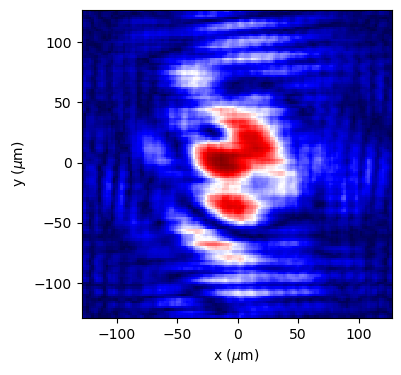

In [10]:
# 不看中间的光束传输过程，可以根据角谱直接计算出z位置的光场分布，结果与考虑传输过程相同
images_input = torch.flip(images_E[0], [0])
field_test = Lens_Layer(distance=torch.tensor(5e-3))(images_input)

# output
plt.rcParams["figure.figsize"] = (4, 4)
fig, ax = plt.subplots(1)
XY_field_out = torch.abs(field_test).T.cpu().numpy()
ax.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')

plt.show()

In [11]:
# 在傅里叶平面上设置一个正方形光阑，光阑矩阵
square_aper = torch.zeros((N_pixels,N_pixels), dtype = torch.double)
L_side = int(N_pixels*1) # 1：全透，1/2中央二分之一区域透光
x1 = int((N_pixels-L_side)/2)
x2 = int((N_pixels+L_side)/2)
square_aper[x1:x2, x1:x2] = 1 # 设置探测器区域

f = 5e-3
field_lens1 = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens1_F1 = propagation_along_z(field_lens1, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)
field_out_lens1_F1[-1] = field_out_lens1_F1[-1] * square_aper
field_out_lens1_F2 = propagation_along_z(field_out_lens1_F1[-1], wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)
field_lens2 = field_out_lens1_F2[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens2 = propagation_along_z(field_lens2, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

YZ_field_lens1_F1 = torch.abs(field_out_lens1_F1[:, N_pixels//2])
YZ_field_lens1_F2 = torch.abs(field_out_lens1_F2[:, N_pixels//2])
YZ_field_lens2 = torch.abs(field_out_lens2[:, N_pixels//2])
YZ_field_total = torch.cat((YZ_field, YZ_field_lens1_F1, YZ_field_lens1_F2, YZ_field_lens2), dim = 0)
z_total = np.arange(0, 4*number_of_z_steps)*z_step # z坐标

C:\Users\zc\AppData\Local\Temp\ipykernel_23168\3885851688.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  field_lens1 = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\2310092833.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\3885851688.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  field_lens2 = field_out_lens1_F2[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\1766724965.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('y ($\mu$m)')


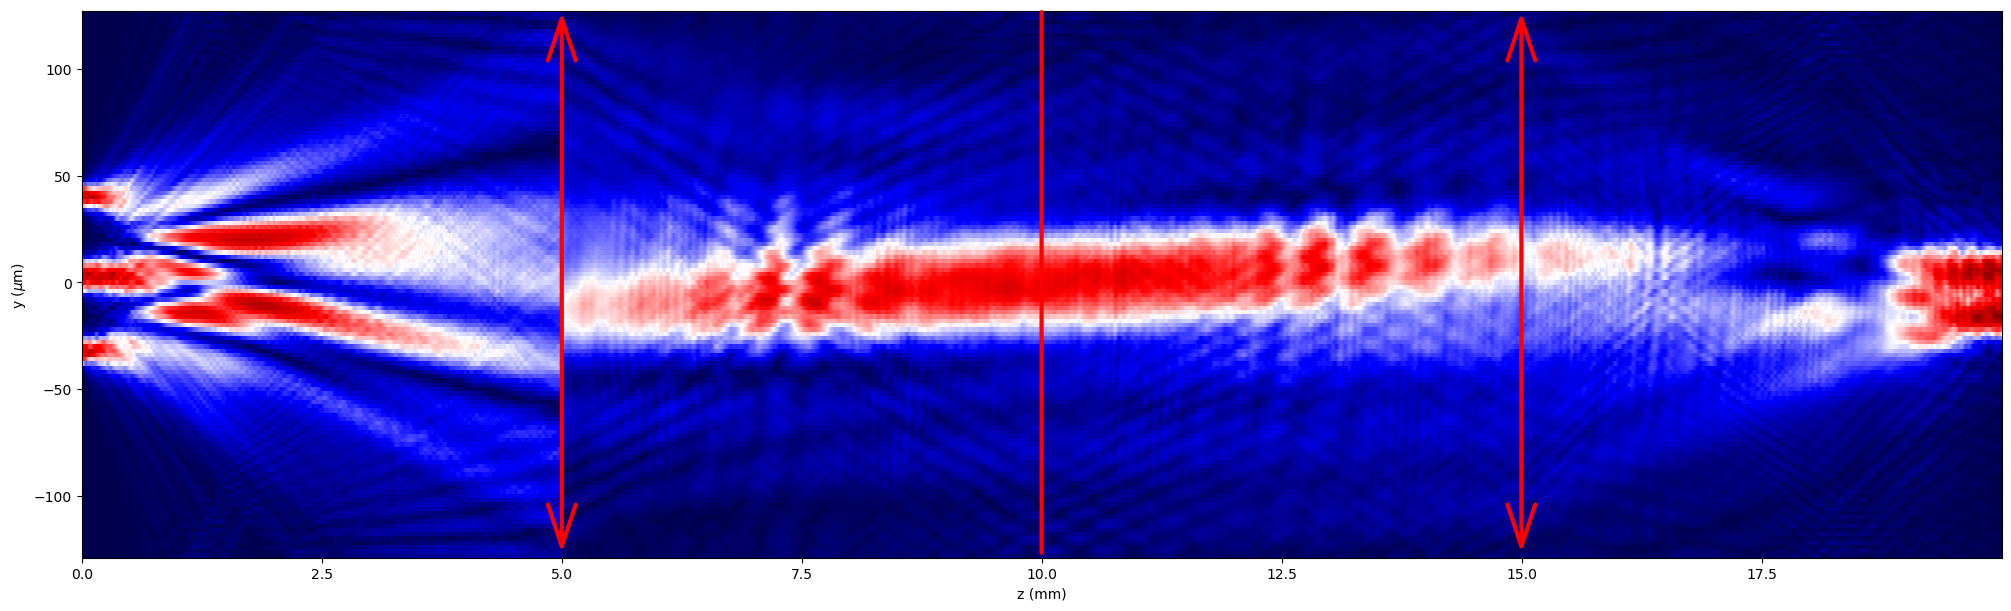

In [12]:
plt.rcParams["figure.figsize"] = (20, 6)
# yx cross-section
fig, ax = plt.subplots(1, constrained_layout=True)
ax.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_total.T, cmap = 'seismic')
ax.set_xlabel('z (mm)')
ax.set_ylabel('y ($\mu$m)')

plt.annotate('', xy=(max(z_total*10**3)/4, -coord_limit*10**6), xytext=(max(z_total*10**3)/4, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)/2, -coord_limit*10**6), xytext=(max(z_total*10**3)/2, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='-', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)*3/4, -coord_limit*10**6), xytext=(max(z_total*10**3)*3/4, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\699772109.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\699772109.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('y ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\699772109.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\699772109.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel('y ($\mu$m)')


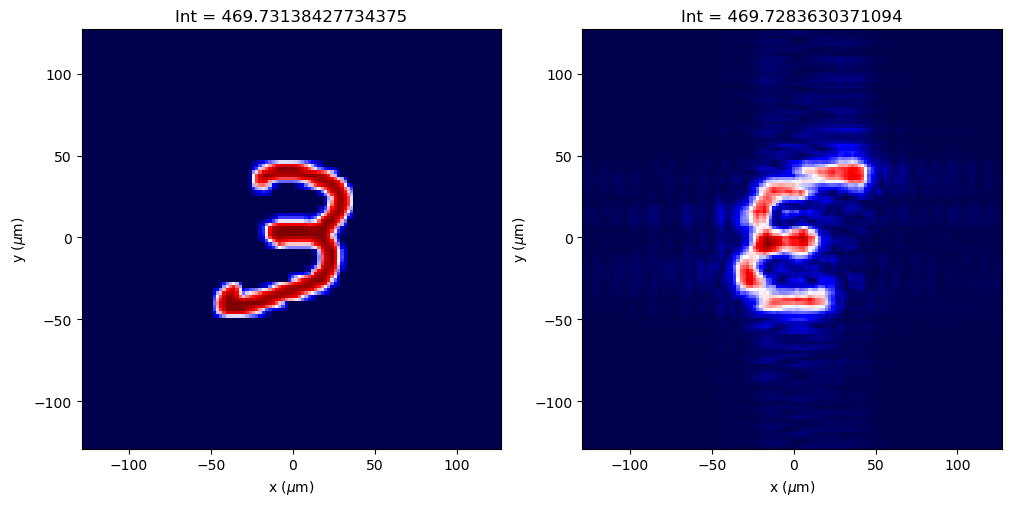

In [13]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap=cmap)
ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')
ax1.set_aspect('equal')
ax1.set_title('Int = {}'.format(torch.pow(abs(torch.tensor(XY_field_in)), 2).sum()))

# output
XY_field_out_lens2 = torch.abs(field_out_lens2[-1]).T
ax2.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out_lens2.T, cmap=cmap)
ax2.set_xlabel('x ($\mu$m)')
ax2.set_ylabel('y ($\mu$m)')
ax2.set_aspect('equal')
ax2.set_title('Int = {}'.format(torch.pow(abs(XY_field_out_lens2), 2).sum()))

plt.axis('square')
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\1659026710.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\1659026710.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('y ($\mu$m)')


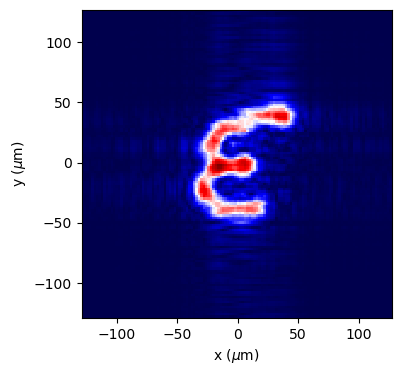

In [14]:
# 在傅里叶平面上设置一个正方形光阑，光阑矩阵
square_aper = torch.zeros((N_pixels,N_pixels), dtype = torch.double)
L_side = int(N_pixels*1) # 1：全透，1/2中央二分之一区域透光
x1 = int((N_pixels-L_side)/2)
x2 = int((N_pixels+L_side)/2)
square_aper[x1:x2, x1:x2] = 1 # 设置探测器区域

# 不看中间的光束传输过程，可以根据角谱直接计算出z位置的光场分布，结果与考虑传输过程相同
images_input = torch.flip(images_E[0], [0])
field_test1 = Lens_Layer(distance=torch.tensor(5e-3))(images_input) # 物面到第一个lens
field_test2 = Diffractive_Layer(distance=torch.tensor(5e-3))(field_test1) # 第一个lens到傅里叶平面
field_test3 = field_test2 * square_aper.to(device) # 经过傅里叶平面的光阑
field_test4 = Lens_Layer(distance=torch.tensor(5e-3))(field_test3) # 傅里叶平面到第二个lens
field_test5 = Propagation_Layer(distance=torch.tensor(5e-3))(field_test4) # 第二个lens到像面

# output
plt.rcParams["figure.figsize"] = (4, 4)
fig, ax = plt.subplots(1)
XY_field_out = torch.abs(field_test5).T.cpu().numpy()
ax.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')

plt.show()

### ***Detectors Layer***

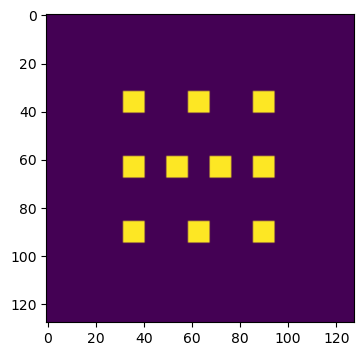

In [15]:
# 生成一行探测器。指定探测器个数N_det，在x方向上生成齐高等间距det_step的一组探测器
# left，right，up和down分别是该行矩形探测器的四个顶点坐标。
def generate_det_row(det_size, start_pos_x, start_pos_y, det_step, N_det):
    p = []
    for i in range(N_det):
        left = start_pos_x+i*(int(det_step)+det_size)
        right = left + det_size
        up = start_pos_y
        down = start_pos_y + det_size
        p.append((up, down, left, right))
    return p

# 生成三行探测器。利用generate_det_row函数生成三行等间距矩形探测器。
def set_det_pos(det_size = 20, start_pos_x = 46, start_pos_y = 46, 
                N_det_sets = [3, 4, 3], det_steps_x = [2, 1, 2], det_steps_y = 2):
    p = []
    for i in range(len(N_det_sets)):
        p.append(generate_det_row(det_size, start_pos_x, start_pos_y+i*(det_steps_y+1)
                                  *det_size, det_steps_x[i]*det_size, N_det_sets[i]))
    return list(itertools.chain.from_iterable(p))

# def set_det_pos(det_size=20, start_pos_x = 46, start_pos_y = 46):
#     p = []
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y, 2*det_size, 3))
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y+3*det_size, 1*det_size, 4))
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y+6*det_size, 2*det_size, 3))
#     return list(itertools.chain.from_iterable(p))

# 获取最终衍射光强在各个探测器上的分布情况
def detector_region(Int):
    detectors_list = []
    total = 0
    full_Int = Int.sum(dim=(1,2)) # 统计总光强
    for det_x0, det_x1, det_y0, det_y1 in detector_pos: # 计算各个探测器区间内的光强占比
        detectors_list.append((Int[:, det_x0 : det_x1, det_y0 : det_y1].sum(dim=(1, 2))/full_Int).unsqueeze(-1))
    for ele in range(0, len(detectors_list)):
        total = total + detectors_list[ele]
    return torch.cat(detectors_list, dim = 1)/total

# 指定生成的十个探测器的位置。
# detector_pos = [
#     (46, 66, 46, 66),
#     (46, 66, 106, 126),
#     (46, 66, 166, 186),
#     (106, 126, 46, 66),
#     (106, 126, 86, 106),
#     (106, 126, 126, 146),
#     (106, 126, 166, 186),
#     (166, 186, 46, 66),
#     (166, 186, 106, 126),
#     (166, 186, 166, 186)

# 定义探测器模型基本参数
det_size = 9
det_pad = (N_pixels - 7*det_size)//2
detector_pos = set_det_pos(det_size, det_pad, det_pad)

# 定义探测器层的图片张量
labels_image_tensors=torch.zeros((10,N_pixels,N_pixels), device = device, dtype = torch.double)
for ind, pos in enumerate(detector_pos):
    pos_l, pos_r, pos_u, pos_d = pos
    labels_image_tensors[ind, pos_l:pos_r, pos_u:pos_d] = 1 # 设置探测器区域
    labels_image_tensors[ind] = labels_image_tensors[ind]/labels_image_tensors[ind].sum() # 归一化探测器层
det_ideal = labels_image_tensors.cpu().numpy().sum(axis = 0)

plt.rcParams["figure.figsize"] = (4, 4)
plt.imshow(det_ideal) # 查看探测器层

### ***D2NN***

In [16]:
# 先做一个模型初始化，将生成的初始随机相位参数与模型分离，以便于后面对其他参数分别训练。
# 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
num_layers = 2
distance_between_layers = 0.004, 0.002, 0.004, 0.005
phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
                                                          astype('float32'))) for _ in range(num_layers)]
# Amp = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
#                                                           astype('float32'))) for _ in range(num_layers)]
# 初始化层间距，预训练时（先只训练相位）设置梯度requires_grad=False。
distance = [torch.nn.Parameter(distance_between_layers[i]*torch.tensor([1])) for i in range(num_layers+2)]

In [17]:
distance[1]

Parameter containing:
tensor([0.0020], requires_grad=True)

In [18]:
class DNN(torch.nn.Module):
    """""""""""""""""""""
    phase & amplitude modulation
    """""""""""""""""""""
    def __init__(self, phase = [], num_layers = 2, wl = 532e-9, N_pixels = 128, pixel_size = 20e-6, 
                 distance = []):

        super(DNN, self).__init__()
        
        # 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
#         self.phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
#                                                           astype('float32')-0.5)) for _ in range(num_layers)]
        # 向网络中添加每层相位板的参数
        for i in range(num_layers):
            self.register_parameter("phase" + "_" + str(i), phase[i])
        # 向网络中添加每层相位板的衰减参数
#         for i in range(num_layers):
#             self.register_parameter("Amp" + "_" + str(i), Amp[i])
        # 向网络中添加层间距的参数
        for i in range(num_layers+2):
            self.register_parameter("distance" + "_" + str(i), distance[i])
        # 定义最大相位
        self.phi_max = np.pi

        # 定义透镜面
        self.lens_layer1 = Lens_Layer()
        
        # 定义中间的衍射层
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Layer(wl, N_pixels, pixel_size, distance[i])
                                                       for i in range(num_layers)])
        
        # 在相位板后加一层饱和吸收体，用ReLU模拟非线性
#         self.relu = torch.nn.ReLU()
        
        # 定义透镜面
        self.lens_layer2 = Lens_Layer(distance=distance[-2])
        
        # 定义最后的探测层
        self.last_diffractive_layer = Propagation_Layer(wl, N_pixels, pixel_size, distance[-1])
        self.sofmax = torch.nn.Softmax(dim=-1)
    
    # 计算多层衍射前向传播
    def forward(self, E):
        E = self.lens_layer1(E)
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            constr_phase = np.pi*phase[index]
            # 这里相当于加了一层sigmoid非线性激活，将相位控制在0到2pi
#             constr_phase = 2*np.pi*torch.sigmoid(phase[index])
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase
            E_phase = E/torch.abs(E)
            I = torch.abs(E)**2
            I_th = torch.mean(I, dim=(-2, -1), keepdim=True)/2
            I_th = (I_th * torch.ones_like(E)).to(dtype=torch.float64)
            I_out = torch.nn.ReLU()(I.to(dtype=torch.float64)-I_th)
            E = torch.sqrt(I_out)*E_phase
        E = self.lens_layer2(E)
        E = self.last_diffractive_layer(E)
        Int = torch.abs(E)**2
#         output = self.sofmax(detector_region(Int))
        output = detector_region(Int)
        return output, Int

In [19]:
a = torch.tensor([[[-1, 1, 1], [4, -4, 4]], [[2, 2, -2], [5, -5, 5]]]).to(dtype=torch.float64)
print(a.size())
print(a)
b = torch.mean(torch.abs(a), dim=(-2, -1), keepdim=True)
print(b.size())
c = torch.ones_like(a)*b
c.size()
print(c)

a-c

torch.Size([2, 2, 3])
tensor([[[-1.,  1.,  1.],
         [ 4., -4.,  4.]],

        [[ 2.,  2., -2.],
         [ 5., -5.,  5.]]], dtype=torch.float64)
torch.Size([2, 1, 1])
tensor([[[2.5000, 2.5000, 2.5000],
         [2.5000, 2.5000, 2.5000]],

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]]], dtype=torch.float64)


tensor([[[-3.5000, -1.5000, -1.5000],
         [ 1.5000, -6.5000,  1.5000]],

        [[-1.5000, -1.5000, -5.5000],
         [ 1.5000, -8.5000,  1.5000]]], dtype=torch.float64)

In [20]:
I = torch.abs(images_E)**2
I_th = torch.mean(I, dim=(-2, -1), keepdim=True)
I_th = I_th * torch.ones_like(images_E)
I_th.shape
I_out = torch.nn.ReLU()(I-I_th)
I_out.shape

torch.Size([200, 128, 128])

In [21]:
model = DNN(phase = phase, distance = distance).to(device)
print(model)

DNN(
  (lens_layer1): Lens_Layer()
  (diffractive_layers): ModuleList(
    (0-1): 2 x Diffractive_Layer()
  )
  (lens_layer2): Lens_Layer()
  (last_diffractive_layer): Propagation_Layer()
  (sofmax): Softmax(dim=-1)
)


In [22]:
# 展示可供训练的参数（因为）
for index, item in model.named_parameters():
    print(index)

phase_0
phase_1
distance_0
distance_1
distance_2
distance_3


In [23]:
# 先只训练相位，层间距先设定0.005。之后再在0.005这个基础上微调训练层间距。
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if name.find('phase') != -1:
        exec('model.' + name + '.requires_grad_(True)')
# for name, param in model.named_parameters():
#     if name.find('Amp') != -1:
#         exec('model.' + name + '.requires_grad_(True)')
    
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 phase_0
	 phase_1


### ***Training***

In [24]:
# 定义训练函数
def train(model, loss_function, optimizer, trainloader, testloader, epochs = 10, device = 'cpu', filename = 'best.pt'):
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
        ep_loss = 0
        # 每个epoch开始时启动Batch_Normalization和Dropout。BN层能够用到每一批数据的均值和方差，Dropout随机取一部分网络连接来训练更新参数。
        model.train()
        correct = 0
        total = 0
        # 加载进度条
        for images, labels in tqdm(trainloader):
            
            images = torch.sqrt(images.to(device).squeeze())
#             images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
            labels = labels.to(device)
            det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
#             det_labels = labels_image_tensors[labels] # 定义各标签的探测器层张量
            
            optimizer.zero_grad() # 梯度清零
            out_label, out_img = model(images) # 得到预测各个探测器上的光强分布以及探测层光强分布
            
            _, predicted = torch.max(out_label, 1) # 找到光强分布占比最大的探测器，并作为预测结果
            correct += (predicted == labels).sum().item() # 得到一个batch的预测结果。如果预测值等于标签值，则正确值加一。
            total += labels.size(0) # 得到一个batch的标签总数

            full_int_img = out_img.sum(axis=(1,2))
#             loss = loss_function(out_img/full_int_img[:,None,None], det_labels) # 光强分布归一化后送入损失函数（与完美探测结果进行比较）
#             loss = loss_function(out_label, det_labels)
            loss = loss_function(out_label, det_labels*0.1)
            
            loss.backward() # 反向传播
            optimizer.step() # 参数更新
            ep_loss += loss.item() # 更新本次epoch的损失
        train_loss_hist.append(ep_loss /len(trainloader)) # 计算平均损失
        train_acc_hist.append(correct /total) # 计算准确率
        #train_acc_hist.append(validate(model, trainloader,device))

        #test_acc_hist.append(validate(model, testloader,device))
        # if test_acc_hist[-1][0]>best_acc:
        #     best_model=copy.deepcopy(model)
        
        ep_loss = 0
        # 不启用Batch Normalization和Dropout。测试过程中要保证BN层的均值和方差不变，且利用到了所有网络连接，即不进行随机舍弃神经元。
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # 停止梯度更新
            for images, labels in tqdm(testloader):
                images = images.to(device).squeeze()
#                 images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
                labels = labels.to(device)
                det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
#                 det_labels = labels_image_tensors[labels]

                out_label, out_img = model(images)
                _, predicted = torch.max(out_label, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                full_int_img = out_img.sum(axis=(1,2))
#                 loss = loss_function(out_img/full_int_img[:,None,None], det_labels)
#                 loss = loss_function(out_label, det_labels)
                loss = loss_function(out_label, det_labels*0.1)
                
                #直接计算损失，无反向传播和梯度更新。
                ep_loss += loss.item()
        test_loss_hist.append(ep_loss / len(testloader))
        test_acc_hist.append(correct / total)
        # 如果最后一次训练的准确率大于之前最好的准确率，则将最后一次的模型保存为最佳模型。
        if test_acc_hist[-1]>best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            state = {
              'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
              'best_acc': best_acc,
              'optimizer' : optimizer.state_dict(),
            }
            torch.save(state, filename)

        print(f"Epoch={epoch} train loss={train_loss_hist[epoch]:.4}, test loss={test_loss_hist[epoch]:.4}")
        print(f"train acc={train_acc_hist[epoch]:.4}, test acc={test_acc_hist[epoch]:.4}")
        print("-----------------------")
        
    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)    
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, model

In [25]:
def custom_loss(imgs, det_labels):
    full_int = imgs.sum(dim=(1,2))
    loss = 1 - (imgs*det_labels).sum(dim=(1,2))/full_int
    return loss.mean()

In [26]:
# 定义衍射模型基本参数
wl = 532e-9
# pixel_size = 10*wl
pixel_size = 2e-6
# 定义模型，损失函数和优化器
model = DNN(phase = phase, num_layers = 2, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
# criterion = custom_loss
# criterion = torch.nn.CrossEntropyLoss().to(device)
criterion = torch.nn.MSELoss(reduction='sum').to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer = torch.optim.Adam(params_to_update, lr=0.002)

In [27]:
# 正式开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 5,  device = device)

  0%|          | 0/300 [00:00<?, ?it/s]C:\Users\zc\AppData\Local\Temp\ipykernel_23168\447105092.py:55: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Copy.cpp:309.)
  I_th = (I_th * torch.ones_like(E)).to(dtype=torch.float64)
100%|██████████| 50/50 [00:04<00:00, 10.32it/s]


Epoch=0 train loss=17.56, test loss=16.77
train acc=0.7262, test acc=0.8934
-----------------------


100%|██████████| 50/50 [00:05<00:00,  9.75it/s]


Epoch=1 train loss=16.65, test loss=16.61
train acc=0.9206, test acc=0.9335
-----------------------


100%|██████████| 50/50 [00:05<00:00,  8.50it/s]


Epoch=2 train loss=16.55, test loss=16.55
train acc=0.9435, test acc=0.9469
-----------------------


100%|██████████| 50/50 [00:04<00:00, 10.18it/s]


Epoch=3 train loss=16.5, test loss=16.51
train acc=0.9542, test acc=0.9533
-----------------------


100%|██████████| 50/50 [00:05<00:00,  9.66it/s]

Epoch=4 train loss=16.47, test loss=16.49
train acc=0.9605, test acc=0.9595
-----------------------


In [28]:
# 查看训练的各个参数，确保这一次只有相位被训练了（requires_grad=True）
for param in model.named_parameters():
    print(param)

('phase_0', Parameter containing:
tensor([[0.6594, 0.2457, 0.7774,  ..., 0.8885, 0.8009, 0.0204],
        [0.4061, 0.3544, 0.1350,  ..., 0.0937, 0.2297, 0.3674],
        [0.5679, 0.8335, 0.2478,  ..., 0.7094, 0.8854, 0.5623],
        ...,
        [1.0497, 0.1104, 0.6822,  ..., 0.9975, 0.7128, 0.4909],
        [0.8403, 0.9316, 0.5729,  ..., 0.3630, 0.1315, 0.9054],
        [0.3552, 0.3222, 0.3351,  ..., 0.5664, 0.2362, 0.9673]],
       device='cuda:0', requires_grad=True))
('phase_1', Parameter containing:
tensor([[-0.1151,  1.0565,  0.9228,  ...,  0.5829,  0.5363,  0.1622],
        [ 0.4921,  0.7939,  0.8465,  ...,  0.5628,  0.0030,  1.3230],
        [ 0.6221,  1.1611,  0.0493,  ...,  0.5752,  1.0806,  1.4198],
        ...,
        [ 0.3532,  1.1335,  0.8002,  ...,  0.5647,  0.5275,  0.7677],
        [ 0.4904,  0.7915,  0.4659,  ...,  0.7539,  0.0503, -0.1513],
        [ 1.3568,  0.7242,  0.4999,  ..., -0.0930,  0.2694,  0.5609]],
       device='cuda:0', requires_grad=True))
('distance

In [29]:
# 全部解禁，相位和层间距都拿来训练
for param in model.parameters():
    param.requires_grad = True

# for name, param in model.named_parameters():
#     if name.find('distance') != -1:
#         exec('model.' + name + '.requires_grad_(True)')

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 phase_0
	 phase_1
	 distance_0
	 distance_1
	 distance_2
	 distance_3


In [30]:
# 加载之前训练好的参数
checkpoint = torch.load('best.pt')
best_acc = checkpoint['best_acc']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [31]:
# 加载损失函数和优化器
criterion = torch.nn.MSELoss(reduction='sum').to(device)
# criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=1e-6)

In [32]:
# 重新开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 4,  device = device)

100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Epoch=0 train loss=16.45, test loss=16.49
train acc=0.9641, test acc=0.9596
-----------------------


100%|██████████| 50/50 [00:05<00:00,  8.85it/s]


Epoch=2 train loss=16.45, test loss=16.49
train acc=0.964, test acc=0.9592
-----------------------


100%|██████████| 50/50 [00:05<00:00,  8.50it/s]

Epoch=3 train loss=16.45, test loss=16.5
train acc=0.9644, test acc=0.9592
-----------------------


In [33]:
for name, param in model.named_parameters():
    print(param)

Parameter containing:
tensor([[0.6593, 0.2456, 0.7774,  ..., 0.8885, 0.8008, 0.0204],
        [0.4060, 0.3544, 0.1350,  ..., 0.0937, 0.2297, 0.3675],
        [0.5678, 0.8335, 0.2478,  ..., 0.7094, 0.8854, 0.5622],
        ...,
        [1.0497, 0.1104, 0.6822,  ..., 0.9976, 0.7128, 0.4908],
        [0.8403, 0.9316, 0.5729,  ..., 0.3630, 0.1315, 0.9054],
        [0.3551, 0.3223, 0.3351,  ..., 0.5664, 0.2362, 0.9673]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.1150,  1.0568,  0.9227,  ...,  0.5831,  0.5362,  0.1621],
        [ 0.4919,  0.7942,  0.8467,  ...,  0.5624,  0.0027,  1.3232],
        [ 0.6221,  1.1609,  0.0493,  ...,  0.5752,  1.0803,  1.4201],
        ...,
        [ 0.3531,  1.1335,  0.8005,  ...,  0.5647,  0.5271,  0.7676],
        [ 0.4904,  0.7914,  0.4661,  ...,  0.7542,  0.0502, -0.1515],
        [ 1.3565,  0.7243,  0.4998,  ..., -0.0931,  0.2693,  0.5608]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0040

In [34]:
def constrain_phase_0_pi(phase_param: torch.Tensor) -> torch.Tensor:
    """
    将“可训练相位参数”(任意实数) 映射为物理相位 [0, π]（单位：rad）。
    训练时 forward 用的也应是同一个口径：π * sigmoid(param)。
    """
    return torch.pi * torch.sigmoid(phase_param)


def quantize_phase_4level(phi_0_pi: torch.Tensor) -> torch.Tensor:
    """
    将 [0, π] 相位量化到四级：0, π/4, π/2, 3π/4（单位：rad）。
    量化策略：就近量化（nearest level）。
    """
    levels = torch.tensor(
        [0.0, 0.25 * torch.pi, 0.5 * torch.pi, 0.75 * torch.pi],
        device=phi_0_pi.device,
        dtype=phi_0_pi.dtype,
    )  # [4]

    # 计算每个像素到 4 个 level 的距离并取最小
    # phi_0_pi: [H, W] or [B, H, W]
    diffs = (phi_0_pi.unsqueeze(-1) - levels).abs()  # [..., 4]
    idx = diffs.argmin(dim=-1)  # [...]
    return levels[idx]


def phase_to_height_sio2_paper(phi_quantized: torch.Tensor) -> torch.Tensor:
    """
    按你给的文献数据，把四级相位映射到 SiO2 蚀刻深度（单位：nm）：
    0 -> 519 nm
    π/4 -> 346 nm
    π/2 -> 173 nm
    3π/4 -> 0 nm

    注意：这是“离散表”映射，不依赖折射率与波长。
    """
    levels = torch.tensor(
        [0.0, 0.25 * torch.pi, 0.5 * torch.pi, 0.75 * torch.pi],
        device=phi_quantized.device,
        dtype=phi_quantized.dtype,
    )
    heights_nm = torch.tensor(
        [519.0, 346.0, 173.0, 0.0],
        device=phi_quantized.device,
        dtype=torch.float32,
    )

    # 因为 phi_quantized 已经是四级之一，直接找匹配的 level
    # 用距离最小来索引更稳健
    diffs = (phi_quantized.unsqueeze(-1) - levels).abs()
    idx = diffs.argmin(dim=-1)
    return heights_nm[idx]


def phase_to_height_physics(phi: torch.Tensor, lambda0=532e-9, n_sio2=1.46, n_env=1.0) -> torch.Tensor:
    """
    可选：基于物理公式的连续映射（单位：m）。
    Δφ = (2π/λ) * (n_sio2 - n_env) * h  =>  h = Δφ * λ / (2π*(n_sio2-n_env))
    若你要复现实验论文给的具体 nm，请优先用 phase_to_height_sio2_paper() 的离散表。
    """
    denom = 2 * torch.pi * (n_sio2 - n_env)
    return phi * lambda0 / denom


def export_quantized_heights_from_model(model: torch.nn.Module, device=None):
    """
    从训练好的 model 导出每层相位\(\rightarrow\)四级相位\(\rightarrow\)高度(nm)。
    返回：list[np.ndarray]，每个元素形状 [N_pixels, N_pixels]（float32，单位 nm）。
    """
    heights = []
    for name, p in model.named_parameters():
        if not name.startswith("phase_"):
            continue
        phase_param = p.detach()
        if device is not None:
            phase_param = phase_param.to(device)

        phi = constrain_phase_0_pi(phase_param)
        phi_q = quantize_phase_4level(phi)
        h_nm = phase_to_height_sio2_paper(phi_q)  # nm
        heights.append(h_nm.cpu().numpy().astype(np.float32))
    return heights


<>:67: SyntaxWarning: invalid escape sequence '\('
<>:67: SyntaxWarning: invalid escape sequence '\('
C:\Users\zc\AppData\Local\Temp\ipykernel_23168\2339766458.py:67: SyntaxWarning: invalid escape sequence '\('
  从训练好的 model 导出每层相位\(\rightarrow\)四级相位\(\rightarrow\)高度(nm)。


### ***Saving***

In [35]:
torch.save(model, 'MNIST_visible wavelength.pth')

In [36]:
# 释放显存
torch.cuda.empty_cache()

### ***Loading***

In [37]:
model = torch.load('MNIST_visible wavelength.pth', weights_only=False)

### ***Data Analysis***

In [38]:
for name, param in model.named_parameters():
    if name.find('distance') != -1:
        print('{:.8f}'.format(param.cpu().detach().numpy()[0]))

0.00400113
0.00199906
0.00400001
0.00499986


In [39]:
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

	 phase_0
	 phase_1
	 distance_0
	 distance_1
	 distance_2
	 distance_3


In [40]:
# 查看
plt.rcParams["figure.figsize"] = (15, 4.5)
def visualize(image, label):
    image_E = torch.sqrt(image)
    out = model(image_E.to(device))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
    ax1.imshow(image.squeeze(), interpolation='none')
    ax1.set_title(f'Input image with\n total intensity {image.squeeze().sum():.2f}')
    output_image = torch.abs(out[1].squeeze()).detach().cpu()
    ax2.imshow(output_image*det_ideal, interpolation='none')
    ax2.set_title(f'Output image with\n total intensity {output_image.squeeze().sum():.2f}')
    dist = out[0].squeeze().detach().cpu()
    ax3.bar(range(len(dist)), dist)
    fig.suptitle("label={}".format(label))
    plt.show()

def mask_visualiztion():
    for name, mask in model.named_parameters():
        if "phase" in name:
            # mask -> sigmoid -> [0,1]，再映射到 [0, π]（rad）
            phi = torch.pi * torch.sigmoid(mask.detach().cpu())

            plt.figure()
            im = plt.imshow(
                phi,
                interpolation="none",
                vmin=0.0,
                vmax=float(torch.pi),
                cmap="twilight",
            )
            plt.title(f"Mask of layer {name} (phase: 0..π rad)")
            cbar = plt.colorbar(im)
            cbar.set_label("Phase (rad)")
            plt.show()

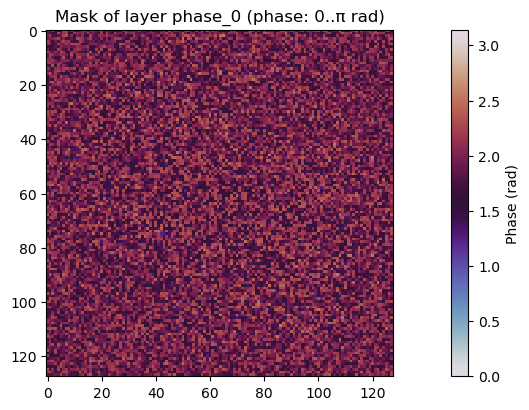

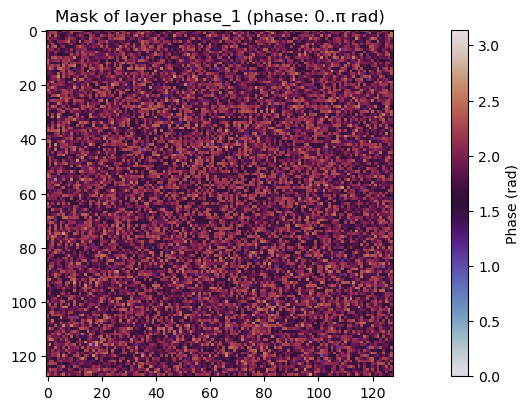

In [41]:
mask_visualiztion()

C:\Users\zc\AppData\Local\Temp\ipykernel_23168\3766266658.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax2.imshow(output_image*det_ideal, interpolation='none')


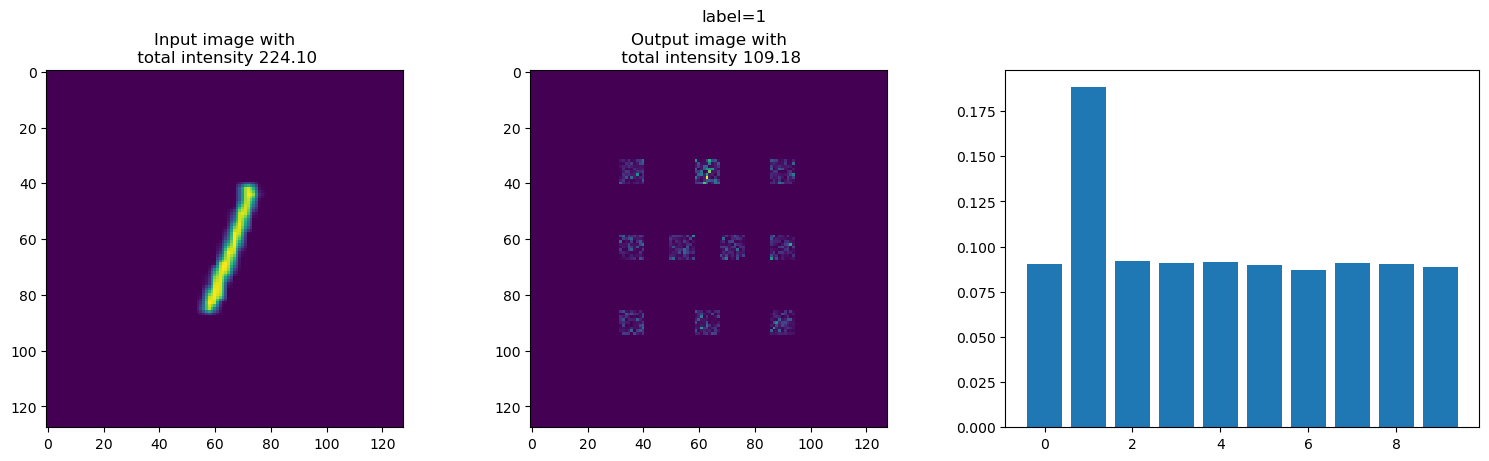

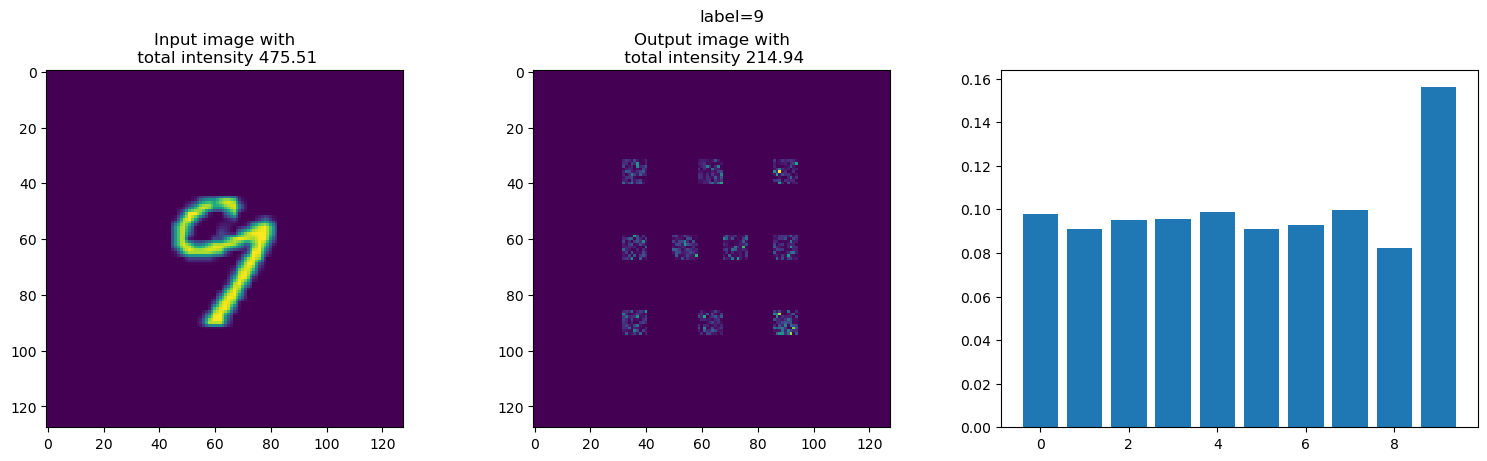

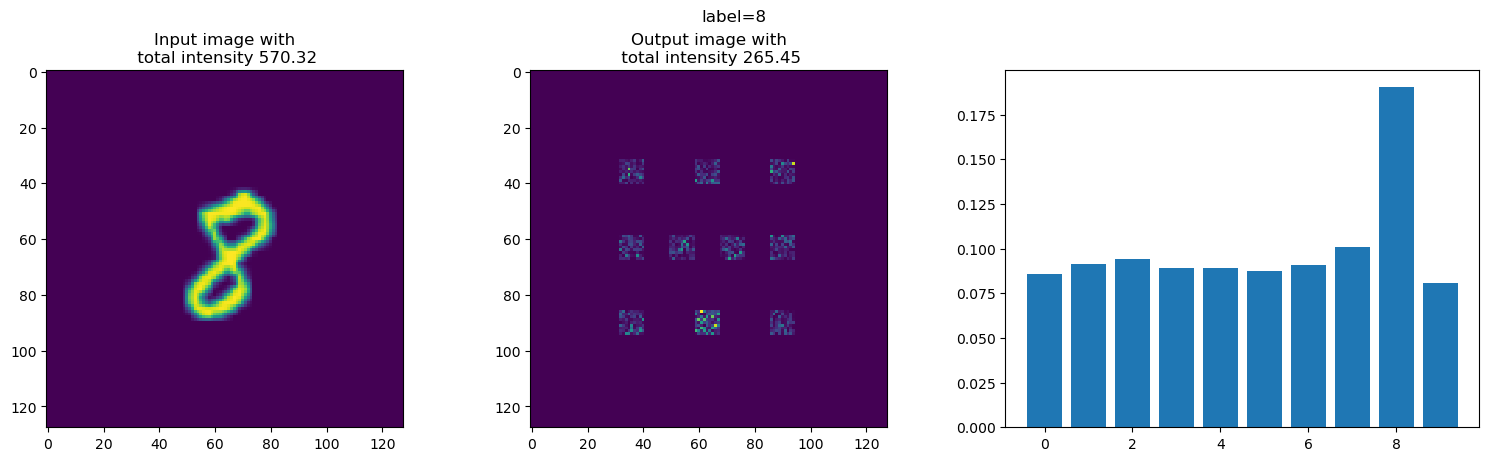

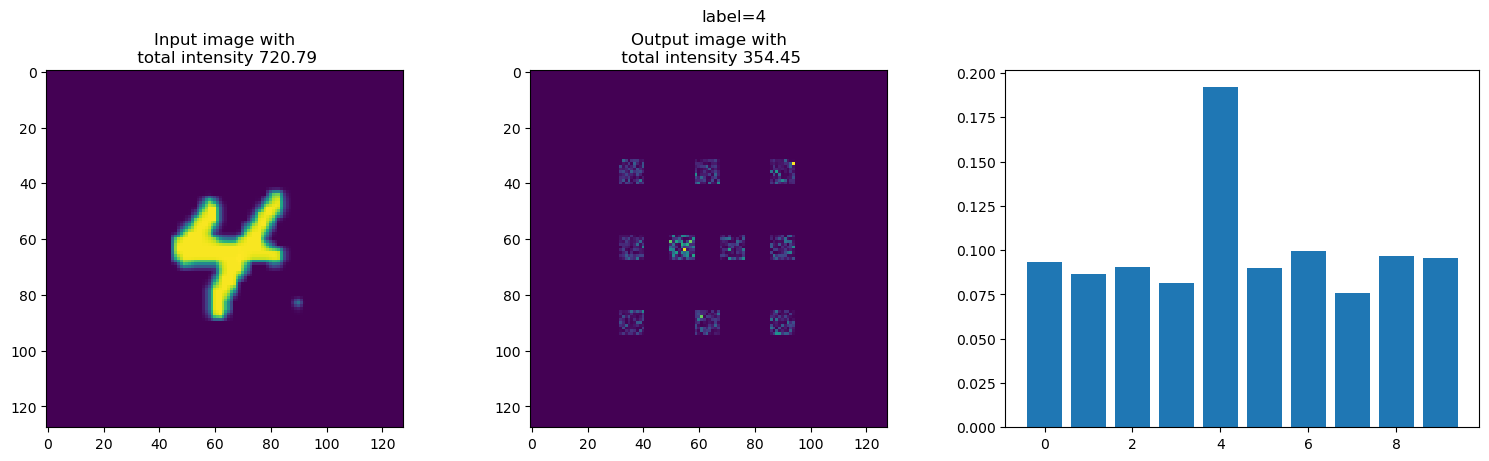

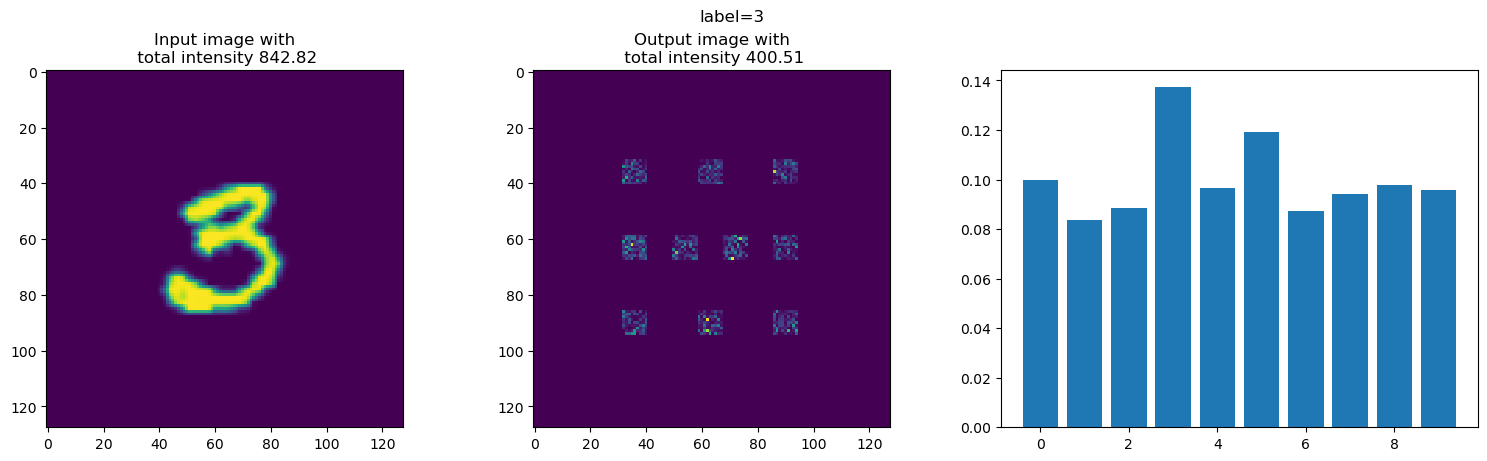

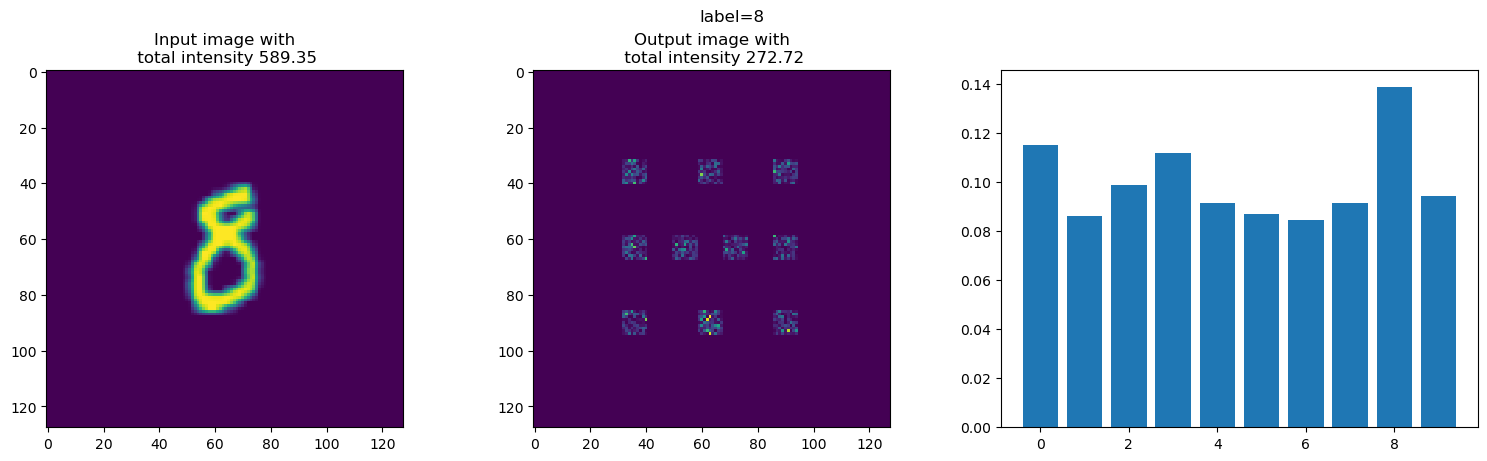

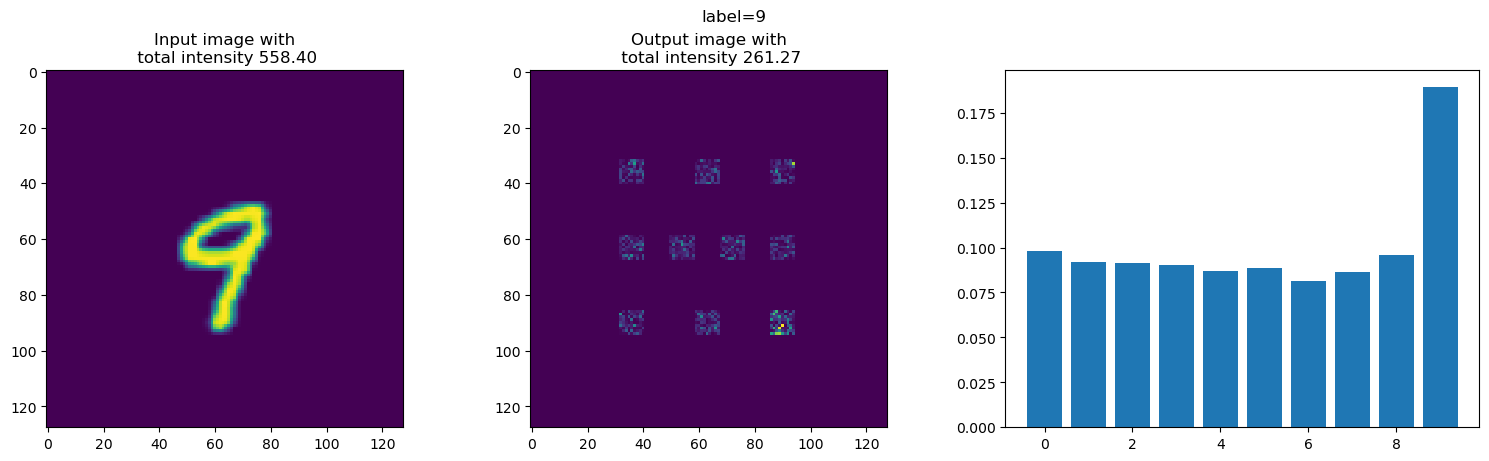

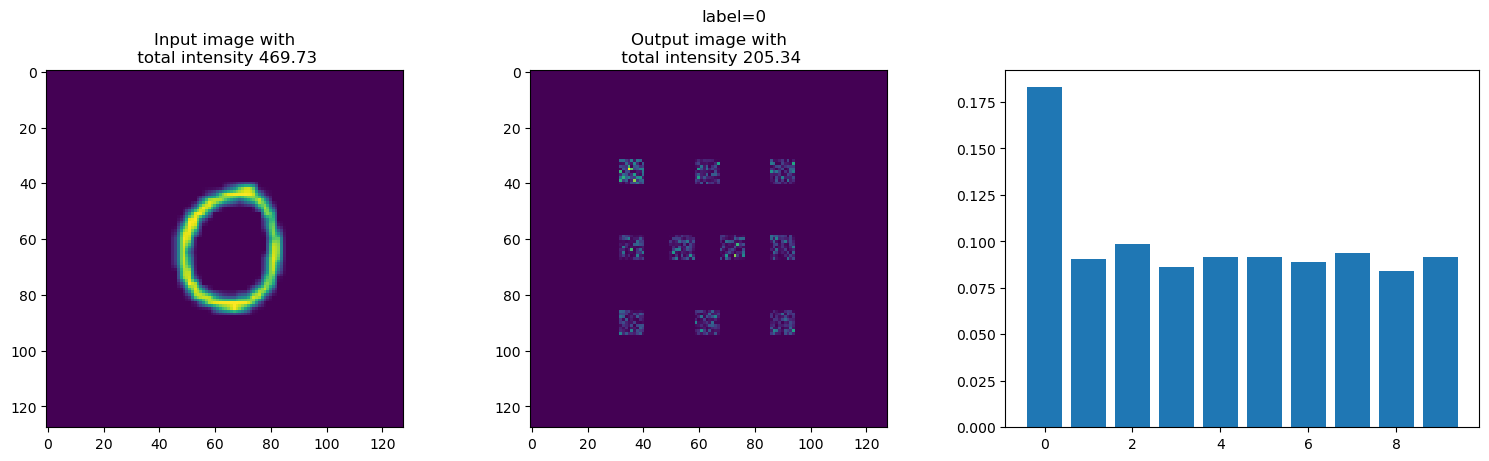

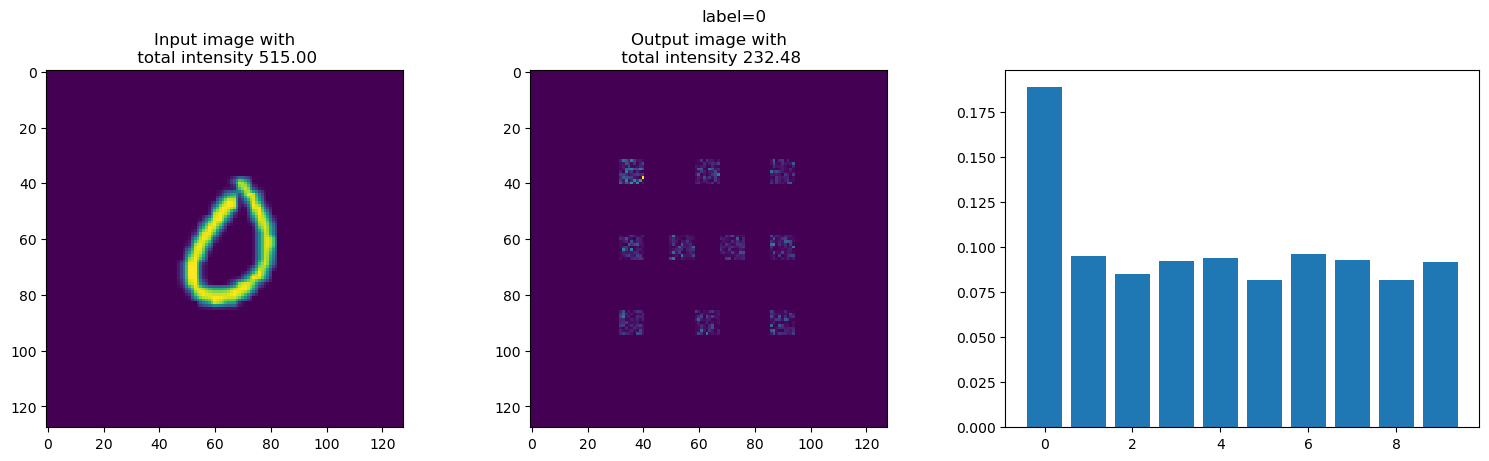

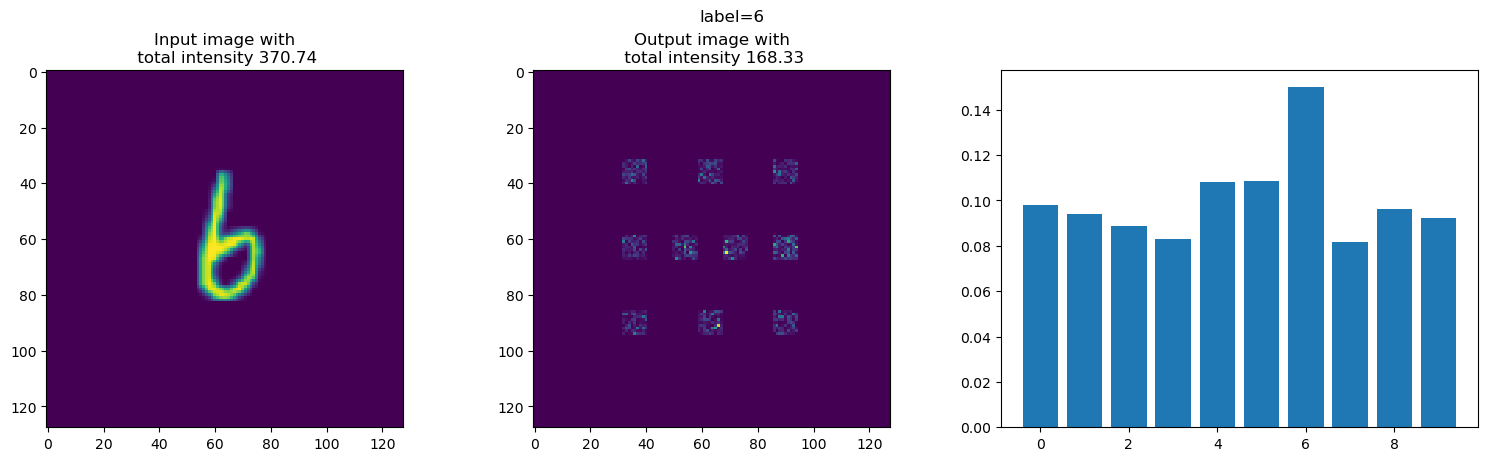

In [42]:
rand_ind = np.random.choice(range(len(val_dataset)), size=10, replace=False)
for ind in rand_ind:
    visualize(val_dataset[ind][0], val_dataset[ind][1])

Saved height_map to: E:\pycharm file\D2NN-with-Pytorch\height_map.npy
  shape=(2, 128, 128), dtype=float32, unit=m
  min=0.0, max=3.4599997889017686e-07


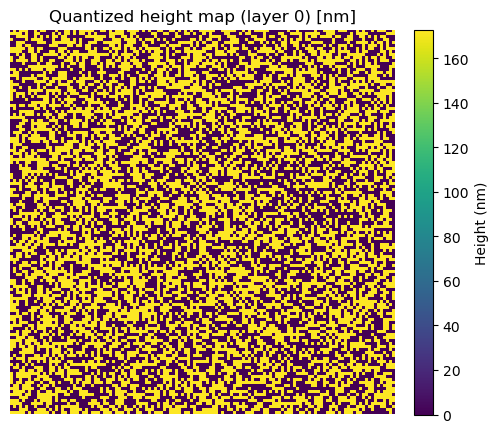

Height levels (nm) and counts:
  0 nm: 7975
  173 nm: 8409


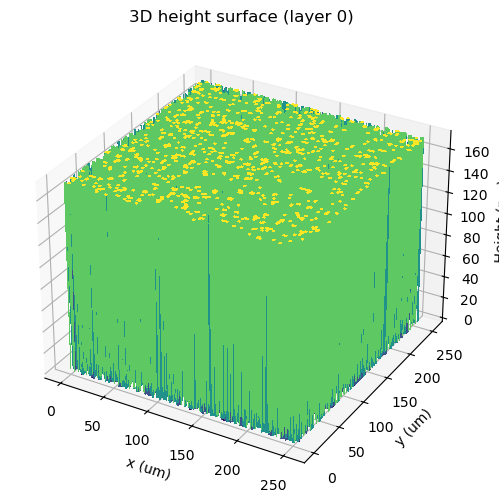

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# ---------------------- 可改参数 ----------------------
layer_index = 0          # 想看第几层：0,1,2,...
pixel_size_um = 2.0      # 像素尺寸（um），例如 2e-6 m -> 2.0 um

# 导出参数
save_height_map = True
height_map_filename = "height_map.npy"   # 将保存到当前工作目录
save_unit = "m"  # "m" 或 "nm"；建议 "m" 以直接用于 Lumerical
# -----------------------------------------------------


def _get_project_dir() -> str:
    # PyCharm 脚本环境用 __file__；交互环境退回 cwd
    try:
        return os.path.dirname(os.path.abspath(__file__))
    except NameError:
        return os.getcwd()


def _collect_all_layer_heights_nm(model) -> np.ndarray:
    """
    从 model.named_parameters() 中收集 phase_0, phase_1, ... 的高度图
    返回：height_map_nm, shape = [num_layer, N, N], dtype=float32, 单位 nm
    """
    params = dict(model.named_parameters())
    phase_keys = [k for k in params.keys() if k.startswith("phase_")]

    def _idx(k: str) -> int:
        # k = "phase_3" -> 3
        return int(k.split("_", 1)[1])

    phase_keys = sorted(phase_keys, key=_idx)
    if not phase_keys:
        raise ValueError("在 model.named_parameters() 中未找到形如 phase_0 的参数。")

    heights = []
    for k in phase_keys:
        p = params[k].detach()
        phi = constrain_phase_0_pi(p)
        phi_q = quantize_phase_4level(phi)
        H_nm = phase_to_height_sio2_paper(phi_q).detach().cpu().numpy().astype(np.float32)  # [N,N] nm
        heights.append(H_nm)

    height_map_nm = np.stack(heights, axis=0)  # [L,N,N]
    return height_map_nm


# 1) 生成全层 height_map（nm）
height_map_nm = _collect_all_layer_heights_nm(model)

# 2) 保存为 .npy（默认保存为 m，更适合 Lumerical）
if save_height_map:
    project_dir = _get_project_dir()
    out_path = os.path.join(project_dir, height_map_filename)

    if save_unit == "m":
        height_map_to_save = (height_map_nm * 1e-9).astype(np.float32)  # nm -> m
    elif save_unit == "nm":
        height_map_to_save = height_map_nm.astype(np.float32)
    else:
        raise ValueError("save_unit 只能是 'm' 或 'nm'。")

    np.save(out_path, height_map_to_save)
    print(f"Saved height_map to: {out_path}")
    print(f"  shape={height_map_to_save.shape}, dtype={height_map_to_save.dtype}, unit={save_unit}")
    print(f"  min={float(height_map_to_save.min())}, max={float(height_map_to_save.max())}")

# 3) 取出你想看的那一层，用于 2D/3D 可视化（保持单位 nm 用于展示）
if not (0 <= layer_index < height_map_nm.shape[0]):
    raise IndexError(f"layer_index={layer_index} 超出范围 0..{height_map_nm.shape[0]-1}")

H = height_map_nm[layer_index]  # [N,N] nm

# 2D 高度热力图
plt.figure(figsize=(6, 5))
im = plt.imshow(H, cmap="viridis", origin="upper")
plt.title(f"Quantized height map (layer {layer_index}) [nm]")
plt.axis("off")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Height (nm)")
plt.show()

# 高度台阶统计
vals, counts = np.unique(H, return_counts=True)
print("Height levels (nm) and counts:")
for v, c in zip(vals, counts):
    print(f"  {v:.0f} nm: {c}")

# 3D 曲面图
Ny, Nx = H.shape
x = np.arange(Nx, dtype=np.float32) * float(pixel_size_um)
y = np.arange(Ny, dtype=np.float32) * float(pixel_size_um)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, H, rstride=1, cstride=1, cmap="viridis", linewidth=0, antialiased=False)
ax.set_title(f"3D height surface (layer {layer_index})")
ax.set_xlabel("x (um)")
ax.set_ylabel("y (um)")
ax.set_zlabel("Height (nm)")
plt.show()


In [53]:
def confusion_matrix(predicted, labels, conf_matrix):
    for p, t in zip(predicted, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
#首先定义一个 分类数*分类数 的空混淆矩阵
conf_matrix = torch.zeros(classes_num, classes_num)
# 使用torch.no_grad()可以显著降低测试用例的GPU占用
with torch.no_grad(): # 停止梯度更新
    for i, (images, labels) in enumerate(val_dataloader):
        images = images.to(device)
        images = torch.sqrt(torch.squeeze(images))
        labels = labels.to(device)

        out_labels, out_images = model(images)
        _, predicted = torch.max(out_labels.data, 1)
        
        #记录混淆矩阵参数
        conf_matrix = confusion_matrix(predicted, labels, conf_matrix)
        conf_matrix = conf_matrix.cpu()

In [54]:
# 1) 安全转换：torch.Tensor -> CPU -> numpy
if isinstance(conf_matrix, torch.Tensor):
    conf_matrix = conf_matrix.detach().to("cpu").numpy()
else:
    # 2) 若本来就是 ndarray/列表等，显式生成 ndarray
    conf_matrix = np.asarray(conf_matrix)

corrects = np.diag(conf_matrix)
per_classes = conf_matrix.sum(axis=1)

print("混淆矩阵总元素个数：{},测试集总个数:{}".format(int(conf_matrix.sum()), BATCH_SIZE * len(val_dataloader)))
np.set_printoptions(suppress=True)
print(conf_matrix)

percent = (corrects / per_classes) * 100

print("每种标签总个数：{}".format("  ".join(["{:.0f}".format(i) for i in per_classes.tolist()])))
print("每种标签预测正确的个数：{}".format("  ".join(["{:.0f}".format(i) for i in corrects.tolist()])))
print("每种标签的识别准确率为：{}".format("%  ".join(["{:.1f}".format(i) for i in percent.tolist()])), end="%")


混淆矩阵总元素个数：10000,测试集总个数:10000
[[ 968.    0.    5.    0.    1.    6.    6.    2.    3.    7.]
 [   1. 1121.    0.    0.    2.    0.    3.   15.    1.    8.]
 [   1.    3.  993.   13.    4.    2.    2.   13.    4.    2.]
 [   1.    2.    4.  968.    0.   19.    0.    3.   10.    9.]
 [   0.    0.    6.    0.  936.    2.    4.    6.    5.   13.]
 [   2.    0.    0.    5.    0.  846.    6.    0.    4.    7.]
 [   4.    5.    3.    0.    8.    7.  933.    0.    4.    1.]
 [   1.    0.    8.    4.    0.    2.    0.  966.    3.    6.]
 [   2.    3.   13.   14.    2.    7.    4.    4.  938.    6.]
 [   0.    1.    0.    6.   29.    1.    0.   19.    2.  950.]]
每种标签总个数：998  1151  1037  1016  972  870  965  990  993  1008
每种标签预测正确的个数：968  1121  993  968  936  846  933  966  938  950
每种标签的识别准确率为：97.0%  97.4%  95.8%  95.3%  96.3%  97.2%  96.7%  97.6%  94.5%  94.2%

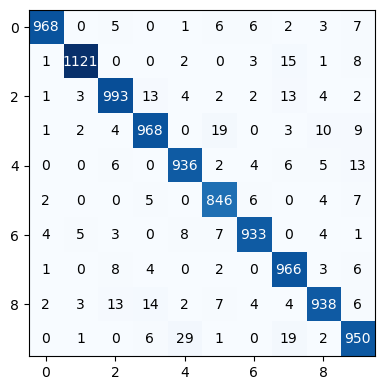

In [55]:
# 绘制混淆矩阵
label_ticks = list()
for i in range(classes_num):
    label_ticks = label_ticks + ['{}'.format(classes[i])]

# 显示数据
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
thresh = conf_matrix.max() / 2	#数值颜色阈值，如果数值超过这个，就颜色加深。
for i in range(classes_num):
    for j in range(classes_num):
        info = int(conf_matrix[j, i])
        plt.text(i, j, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")
plt.show()

In [56]:
# 将模型中的phase导出来
phase = []
for param in model.named_parameters():
    phase.append(param[1])

In [57]:
phase[0].shape

torch.Size([128, 128])

In [ ]:
import os
import glob
import importlib.util
import numpy as np


def load_lumapi(lumapi_path: str):
    spec = importlib.util.spec_from_file_location("lumapi", lumapi_path)
    if spec is None or spec.loader is None:
        raise RuntimeError("无法加载 lumapi，请检查路径")
    lumapi = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(lumapi)
    return lumapi


def get_project_dir() -> str:
    # .py 脚本有 __file__；notebook 没有 __file__
    try:
        return os.path.dirname(os.path.abspath(__file__))
    except NameError:
        return os.getcwd()


def resolve_existing_file(project_dir: str, filename: str) -> str:
    """
    在 project_dir / cwd / 递归子目录中查找文件，找不到就抛出清晰错误。
    """
    candidates = [
        os.path.join(project_dir, filename),
        os.path.join(os.getcwd(), filename),
    ]
    for p in candidates:
        if os.path.isfile(p):
            return p

    patterns = [
        os.path.join(project_dir, "**", filename),
        os.path.join(os.getcwd(), "**", filename),
    ]
    for pat in patterns:
        hits = [h for h in glob.glob(pat, recursive=True) if os.path.isfile(h)]
        if hits:
            # 如果有多个同名文件，取第一个；需要更严格可自行改为报错提示全部 hits
            return hits[0]

    raise FileNotFoundError(
        f"找不到文件 `{filename}`。\n"
        f"cwd={os.getcwd()}\n"
        f"project_dir={project_dir}\n"
        "请确认该文件在项目内，或把路径改成其真实绝对路径。"
    )


def main():
    # ---------- 路径 ----------
    project_dir = get_project_dir()
    lumapi_path = r"D:\Program Files\Lumerical\v241\api\python\lumapi.py"

    # 自动解析 height_map.npy 的真实位置（修复 FileNotFoundError）
    height_map_path = resolve_existing_file(project_dir, "height_map.npy")

    out_fsp_path = os.path.join(project_dir, "D2NN_visible_532nm_memory_safe.fsp")

    # ---------- 基本参数 ----------
    lumapi = load_lumapi(lumapi_path)

    wl0 = 532e-9                   # 可见光 532nm（修复你旧脚本里 750e-6 的单位错误）
    n_material = 1.46              # SiO2 近似
    background_index = 1.0

    # 网络尺寸与像素
    size = 128
    pixel_size = 2e-6
    x_span = pixel_size
    y_span = pixel_size

    # 层数与传播距离（毫米级在 FDTD 很吃内存；这里保留你的设置）
    num_layer = 2
    z_between_layers = 4e-3
    z_last_to_detector = 5e-3

    # ---------- 载入高度图（并做强校验，避免 shape/索引错误） ----------
    height_map = np.load(height_map_path)
    height_map = np.asarray(height_map, dtype=float)

    if height_map.ndim != 3:
        raise ValueError(f"`height_map.npy` 需要是 3D 数组 [num_layer,size,size]，实际 ndim={height_map.ndim}")
    if height_map.shape[0] != num_layer or height_map.shape[1] != size or height_map.shape[2] != size:
        raise ValueError(
            f"`height_map` 期望 shape=[{num_layer},{size},{size}]，实际={height_map.shape}。\n"
            "请让 num_layer/size 与 height_map.npy 匹配，或改这里的参数。"
        )

    max_thickness = 50e-6
    height_map = np.clip(height_map, 0.0, max_thickness)
    max_h = float(np.max(height_map))

    # ---------- 建模维度 ----------
    use_3d = True  # D2NN 本质是 2D 阵列；这里用 3D
    hide = True

    fdtd = lumapi.FDTD(hide=hide)
    fdtd.groupscope("::model")

    # 全局源/监视器设置：单频减少存储
    fdtd.setglobalsource("wavelength start", wl0)
    fdtd.setglobalsource("wavelength stop", wl0)
    fdtd.setglobalmonitor("use source limits", 1)
    fdtd.setglobalmonitor("use linear wavelength spacing", 1)

    # ---------- FDTD 仿真区域 ----------
    use_3d = True  # True -> 3D, False -> 2D(即 Lumerical 的 "2D")

    fdtd.addfdtd()

    # Lumerical 这里期望的是字符串: "2D" / "3D"
    fdtd.set("dimension", "3D" if use_3d else "2D")

    # 坐标习惯：让结构从 (0,0) 附近开始铺，中心放在中间
    x0 = size * x_span / 2.0
    y0 = -size * y_span / 2.0

    pad_xy = 6 * pixel_size
    sim_x_span = size * x_span + 2 * pad_xy
    sim_y_span = size * y_span + 2 * pad_xy

    z_front = 2e-6
    z_back = 2e-6
    z_min = -z_front - max_h
    z_max = (num_layer - 1) * z_between_layers + z_last_to_detector + z_back

    fdtd.set("x", x0)
    fdtd.set("x span", sim_x_span)
    if use_3d:
        fdtd.set("y", y0)
        fdtd.set("y span", sim_y_span)
    fdtd.set("z min", z_min)
    fdtd.set("z max", z_max)

    # PML 边界
    fdtd.set("x min bc", "PML")
    fdtd.set("x max bc", "PML")
    if use_3d:
        fdtd.set("y min bc", "PML")
        fdtd.set("y max bc", "PML")
    fdtd.set("z min bc", "PML")
    fdtd.set("z max bc", "PML")

    fdtd.set("background index", background_index)

    # 全局网格：传播区用粗网格，结构区用 override 加细（省内存）
    fdtd.set("mesh accuracy", 2)

    # ---------- 源：等效激光准直（平面波 + 有限尺寸） ----------
    fdtd.addplane()
    fdtd.set("name", "source")
    fdtd.set("injection axis", "z")
    fdtd.set("direction", "forward")
    fdtd.set("x", x0)
    fdtd.set("x span", size * x_span)
    if use_3d:
        fdtd.set("y", y0)
        fdtd.set("y span", size * y_span)  # 修复：不要写成 size*x_span
    fdtd.set("z", z_min + 1e-6)
    fdtd.set("wavelength start", wl0)
    fdtd.set("wavelength stop", wl0)

    # ---------- 探测器：功率监视器 ----------
    det_z = (num_layer - 1) * z_between_layers + z_last_to_detector
    fdtd.addpower()
    fdtd.set("name", "detector_power")
    fdtd.set("monitor type", "2D Z-normal")
    fdtd.set("x", x0)
    fdtd.set("x span", size * x_span)
    if use_3d:
        fdtd.set("y", y0)
        fdtd.set("y span", size * y_span)
    fdtd.set("z", det_z)

    # ---------- 可选调试 monitor（范围不要覆盖整段毫米传播） ----------
    fdtd.addprofile()
    fdtd.set("name", "xz_profile_near_layers")
    fdtd.set("monitor type", "2D Y-normal")  # x-z 面
    fdtd.set("x", x0)
    fdtd.set("x span", size * x_span)
    if use_3d:
        fdtd.set("y", y0)
    fdtd.set("z min", -max_h - 2e-6)
    fdtd.set("z max", (num_layer - 1) * z_between_layers + 2e-6)

    # ---------- 局部 mesh override：只覆盖结构附近 ----------
    fdtd.addmesh()
    fdtd.set("name", "mesh_near_structures")
    fdtd.set("x", x0)
    fdtd.set("x span", size * x_span)
    if use_3d:
        fdtd.set("y", y0)
        fdtd.set("y span", size * y_span)

    z_struct_min = -max_h - 1e-6
    z_struct_max = (num_layer - 1) * z_between_layers + 1e-6
    fdtd.set("z min", z_struct_min)
    fdtd.set("z max", z_struct_max)

    fdtd.set("override x mesh", 1)
    if use_3d:
        fdtd.set("override y mesh", 1)
    fdtd.set("override z mesh", 1)
    fdtd.set("set maximum mesh step", 1)

    dx = 200e-9
    dy = 200e-9
    dz = 200e-9
    fdtd.set("dx", dx)
    if use_3d:
        fdtd.set("dy", dy)
    fdtd.set("dz", dz)

    # ---------- 构建 D2NN 层：每层一个 structure group ----------
    material_name = "<Object defined dielectric>"

    for l in range(num_layer):
        groupname = f"diffraction_layer_{l}"
        fdtd.addstructuregroup()
        fdtd.set("name", groupname)
        fdtd.groupscope(groupname)

        layer_z = l * z_between_layers
        hm2d = height_map[l]  # shape: [size,size]

        for j in range(size):
            for i in range(size):
                h = float(hm2d[j, i])  # 修复：必须用 [j,i]，不能写成 [l][i]
                if h <= 0.0:
                    continue

                fdtd.addrect()
                fdtd.set("name", f"pix_{l}_{i}_{j}")  # 保证唯一
                fdtd.set("x", x_span / 2 + i * x_span)
                fdtd.set("x span", x_span)
                if use_3d:
                    fdtd.set("y", -y_span / 2 - j * y_span)
                    fdtd.set("y span", y_span)
                fdtd.set("z max", layer_z)
                fdtd.set("z min", layer_z - h)
                fdtd.set("material", material_name)
                fdtd.set("index", n_material)

        fdtd.groupscope("::model")

    # ---------- 保存并关闭 ----------
    fdtd.save(out_fsp_path)
    fdtd.close()

    print("Loaded height_map from:", height_map_path, "shape=", height_map.shape)
    print("Saved:", out_fsp_path)


if __name__ == "__main__":
    main()


In [ ]:
# 写一个测试模型，用于查看中间层的输出图案
class DNN_test(torch.nn.Module):
    def __init__(self, phase=[], num_layers=5, wl = 532e-9, N_pixels = 128, pixel_size = 10*wl, 
                 distance = []):

        super(DNN_test, self).__init__()
        
        # 定义中间的衍射层
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Layer(wl, N_pixels, pixel_size, distance[i])
                                                       for i in range(num_layers)])
        # 定义最后的探测层
        self.last_diffractive_layer = Propagation_Layer(wl, N_pixels, pixel_size, distance[-1])
        self.sofmax = torch.nn.Softmax(dim=-1)
    
    # 计算多层衍射前向传播
    def forward(self, E):
        E_out = []
        Int = []
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            # 这里相当于加了一层sigmoid非线性激活，将相位控制在0到2pi
#             constr_phase = 2*torch.pi*torch.sigmoid(self.phase[index])
            constr_phase = np.pi * torch.sigmoid(self.phase_0)
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase
            E_out.append(E)
        E_out.append(self.last_diffractive_layer(E_out[-1]))
        for i in range(len(E_out)):
            Int.append(torch.abs(E_out[i])**2)
        return Int

In [ ]:

model_test = DNN_test(phase = phase, num_layers = 1, wl = wl, pixel_size = pixel_size, distance = distance).to(device)

In [ ]:
mid_img = model_test(images_E)

In [ ]:
images_E.shape

In [ ]:
len(mid_img[0])

In [ ]:
# Batch里第2个样品的原图
plt.imshow(images_E[0].cpu().detach().numpy())

In [ ]:
# Batch里第2个样品在第1层的图案
plt.imshow(mid_img[1][0].cpu().detach().numpy()*det_ideal)